<a href="https://colab.research.google.com/drive/1dKE1Fs_QxA0gaErRAEuHsyp4QFAI1wQl" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Problem 1: Take at Home  (45 points)

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics. 

In [1]:
import os
import cv2
import re
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KDTree
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.models import resnet50, ResNet50_Weights

### Part 1 Loading of Dataset in Colab (5 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [2]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf /content/lfw.tgz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open '/content/lfw.tgz'


In [3]:
# read all images 
filelist = []

for root, dirs, files in os.walk("./lfw"):
	for file in files:
        #append the file name to the list
		filelist.append(os.path.join(root,file))
        
# transfer all images to tensors
data_size = len(filelist)
img_size = (224,224)
data = torch.zeros(data_size, 224, 224, 3)

for i, file in enumerate(filelist): 
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    # range from 0 to 1
    image = image/255.0
    image = torch.from_numpy(image)
    data[i] = image

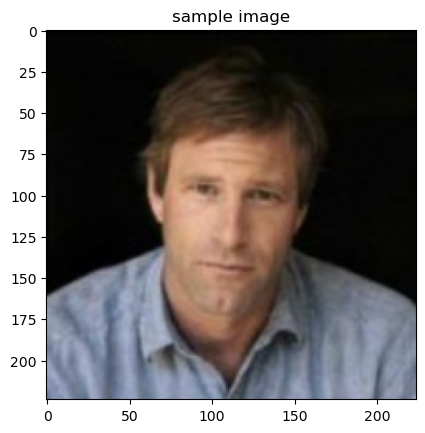

In [4]:
testimg = data[0].to('cpu').numpy()
plt.title("sample image")
plt.imshow(testimg[:,:,::-1])

### Part 2 Using CNN for Feature Extraction (25 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to: 

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet. 
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


In [5]:
pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [6]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# create dataloader for modeling
dataloader = DataLoader(data.permute(0,3,1,2), batch_size=128, shuffle=False)

In [8]:
# feed data to model, get the last second layer's features

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


# using correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device=device)
data = data.to(device=device)

# hook last second layer's features
pretrained_model.eval()
pretrained_model.avgpool.register_forward_hook(get_activation('avgpool'))

# get features of each image
features_list = []
for batch_idx, samples in enumerate(dataloader):
    pretrained_model(samples.to(device))
    feature = torch.squeeze(activation['avgpool'])
    features_list.append(feature)
data_features = torch.cat(features_list)

# create a dict
features_dict = dict(zip(filelist, features_list))

### Part 3 Retrieving most similar images (15 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to 5 query images of your choice. Choose the results that best illustrate the effectiveness of your system. 


In [9]:
# sample 3 images from data as test images
sample_size = 3
query_indices = np.random.choice(np.arange(0, data_size), size=sample_size, replace=False)
selected_features = data_features[query_indices]

# also get test images outside of the data
testimgslist = []
for root, dirs, files in os.walk("./testimg"):
	for file in files:
        #append the file name to the list
		testimgslist.append(os.path.join(root,file))       
        
test_imgs = torch.zeros(len(testimgslist), 224, 224, 3)

for i, file in enumerate(testimgslist): 
    image = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    # range from 0 to 1
    image = image/255.0
    image = torch.from_numpy(image)
    test_imgs[i] = image

# fit testimgs and get their features
pretrained_model(test_imgs.permute(0,3,1,2).to(device))
test_features = torch.squeeze(activation['avgpool'])             

In [10]:
# use nearest neighbor to find similarities
leaf_size = 50
sim_img_size = 10
nn_tree = KDTree(data_features.cpu(), leaf_size=leaf_size)              
indata_similar_dists, indata_similar_indices = nn_tree.query(selected_features.cpu(), k=sim_img_size)   
outdata_similar_dists, outdata_similar_indices = nn_tree.query(test_features.cpu(), k=sim_img_size)  

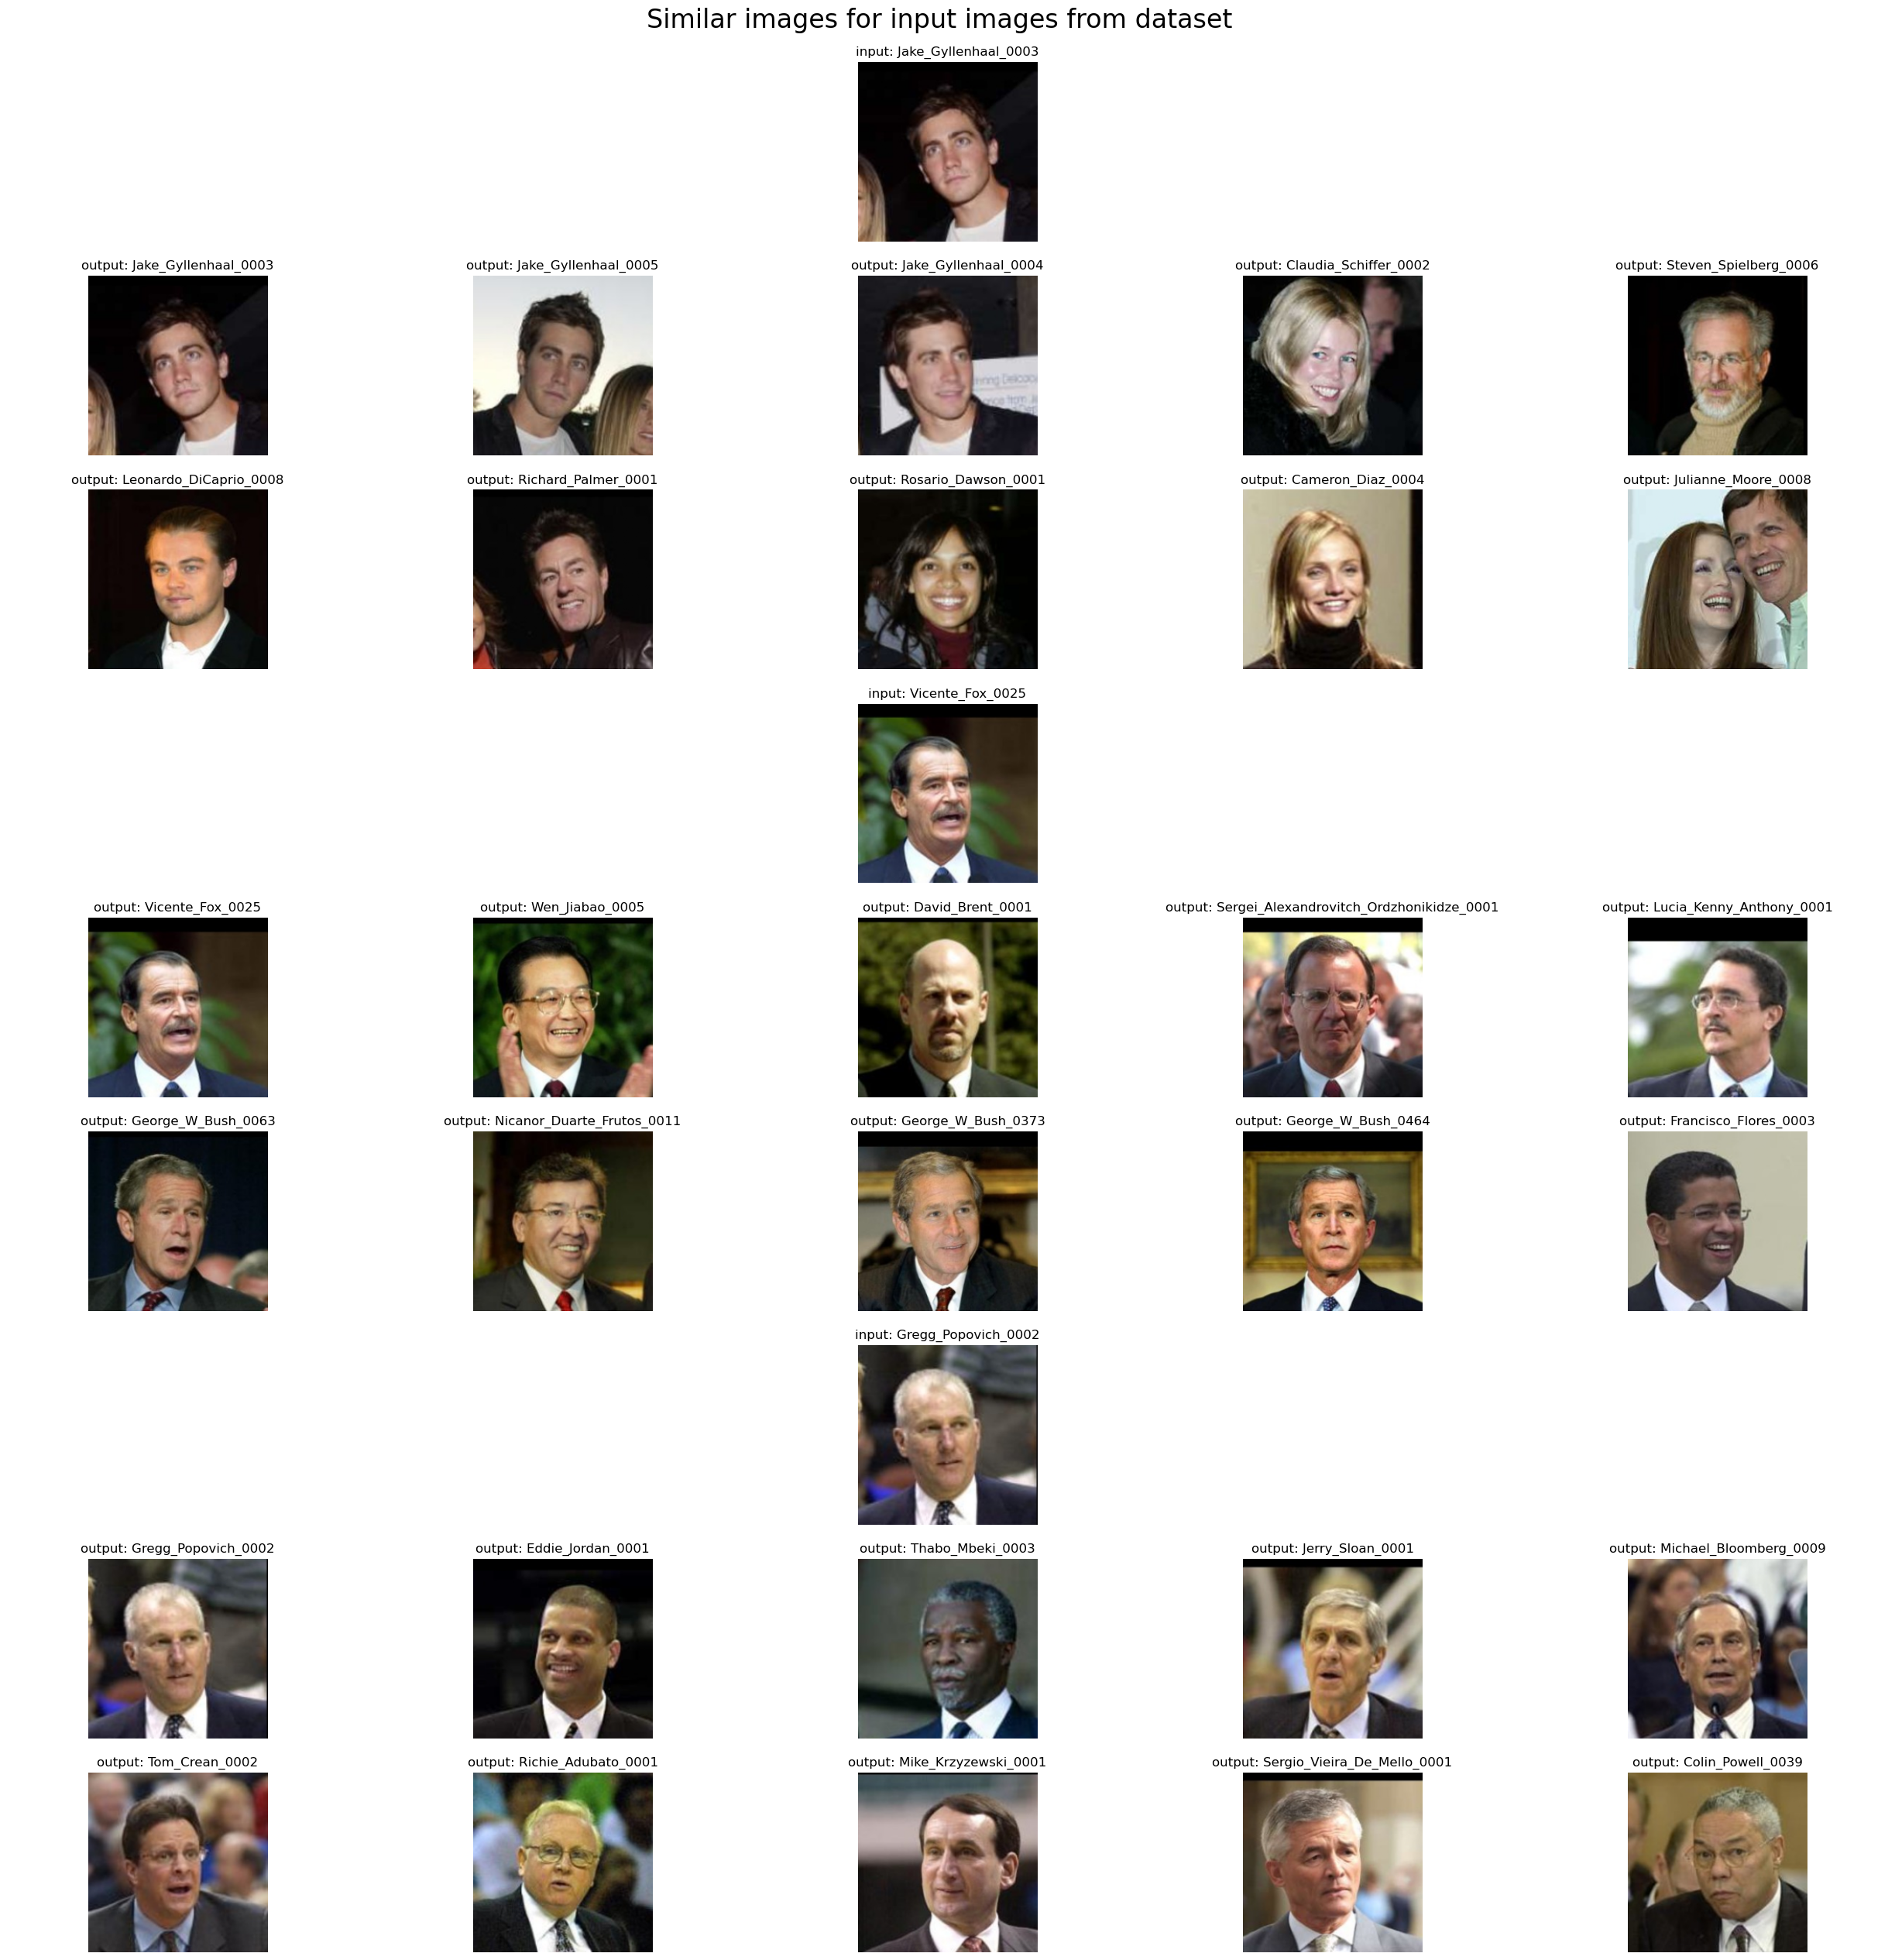

In [11]:
# print similar images indata
fig, axes = plt.subplots(int(sample_size*3), int(sim_img_size/2), figsize=(25, 25))
fig.tight_layout()

# hide all subplots axis
for axr in axes:
    for ax in axr:
        ax.set_axis_off()
        
for i, r in enumerate(range(0, len(axes), 3)):
    # plot original images
    testimg = data[query_indices[i]].to('cpu').numpy()
    testimg_name = re.split(r'\\|\.', filelist[query_indices[i]])[-2]
    axes[r, int(sim_img_size/4)].set_title('input: ' + testimg_name)
    axes[r, int(sim_img_size/4)].imshow(testimg[:,:,::-1])
    # plot similar images
    for k in range(0, sim_img_size):
        pr = r + 1 if  k < int(sim_img_size/2) else r + 2
        pl = k % int(sim_img_size/2)
        testimg = data[indata_similar_indices[i][k]].to('cpu').numpy()
        testimg_name = re.split(r'\\|\.', filelist[indata_similar_indices[i][k]])[-2]
        axes[pr, pl].set_title('output: ' + testimg_name)
        axes[pr, pl].imshow(testimg[:,:,::-1])
fig.suptitle('Similar images for input images from dataset', y=1.02, fontsize=24)
plt.show()

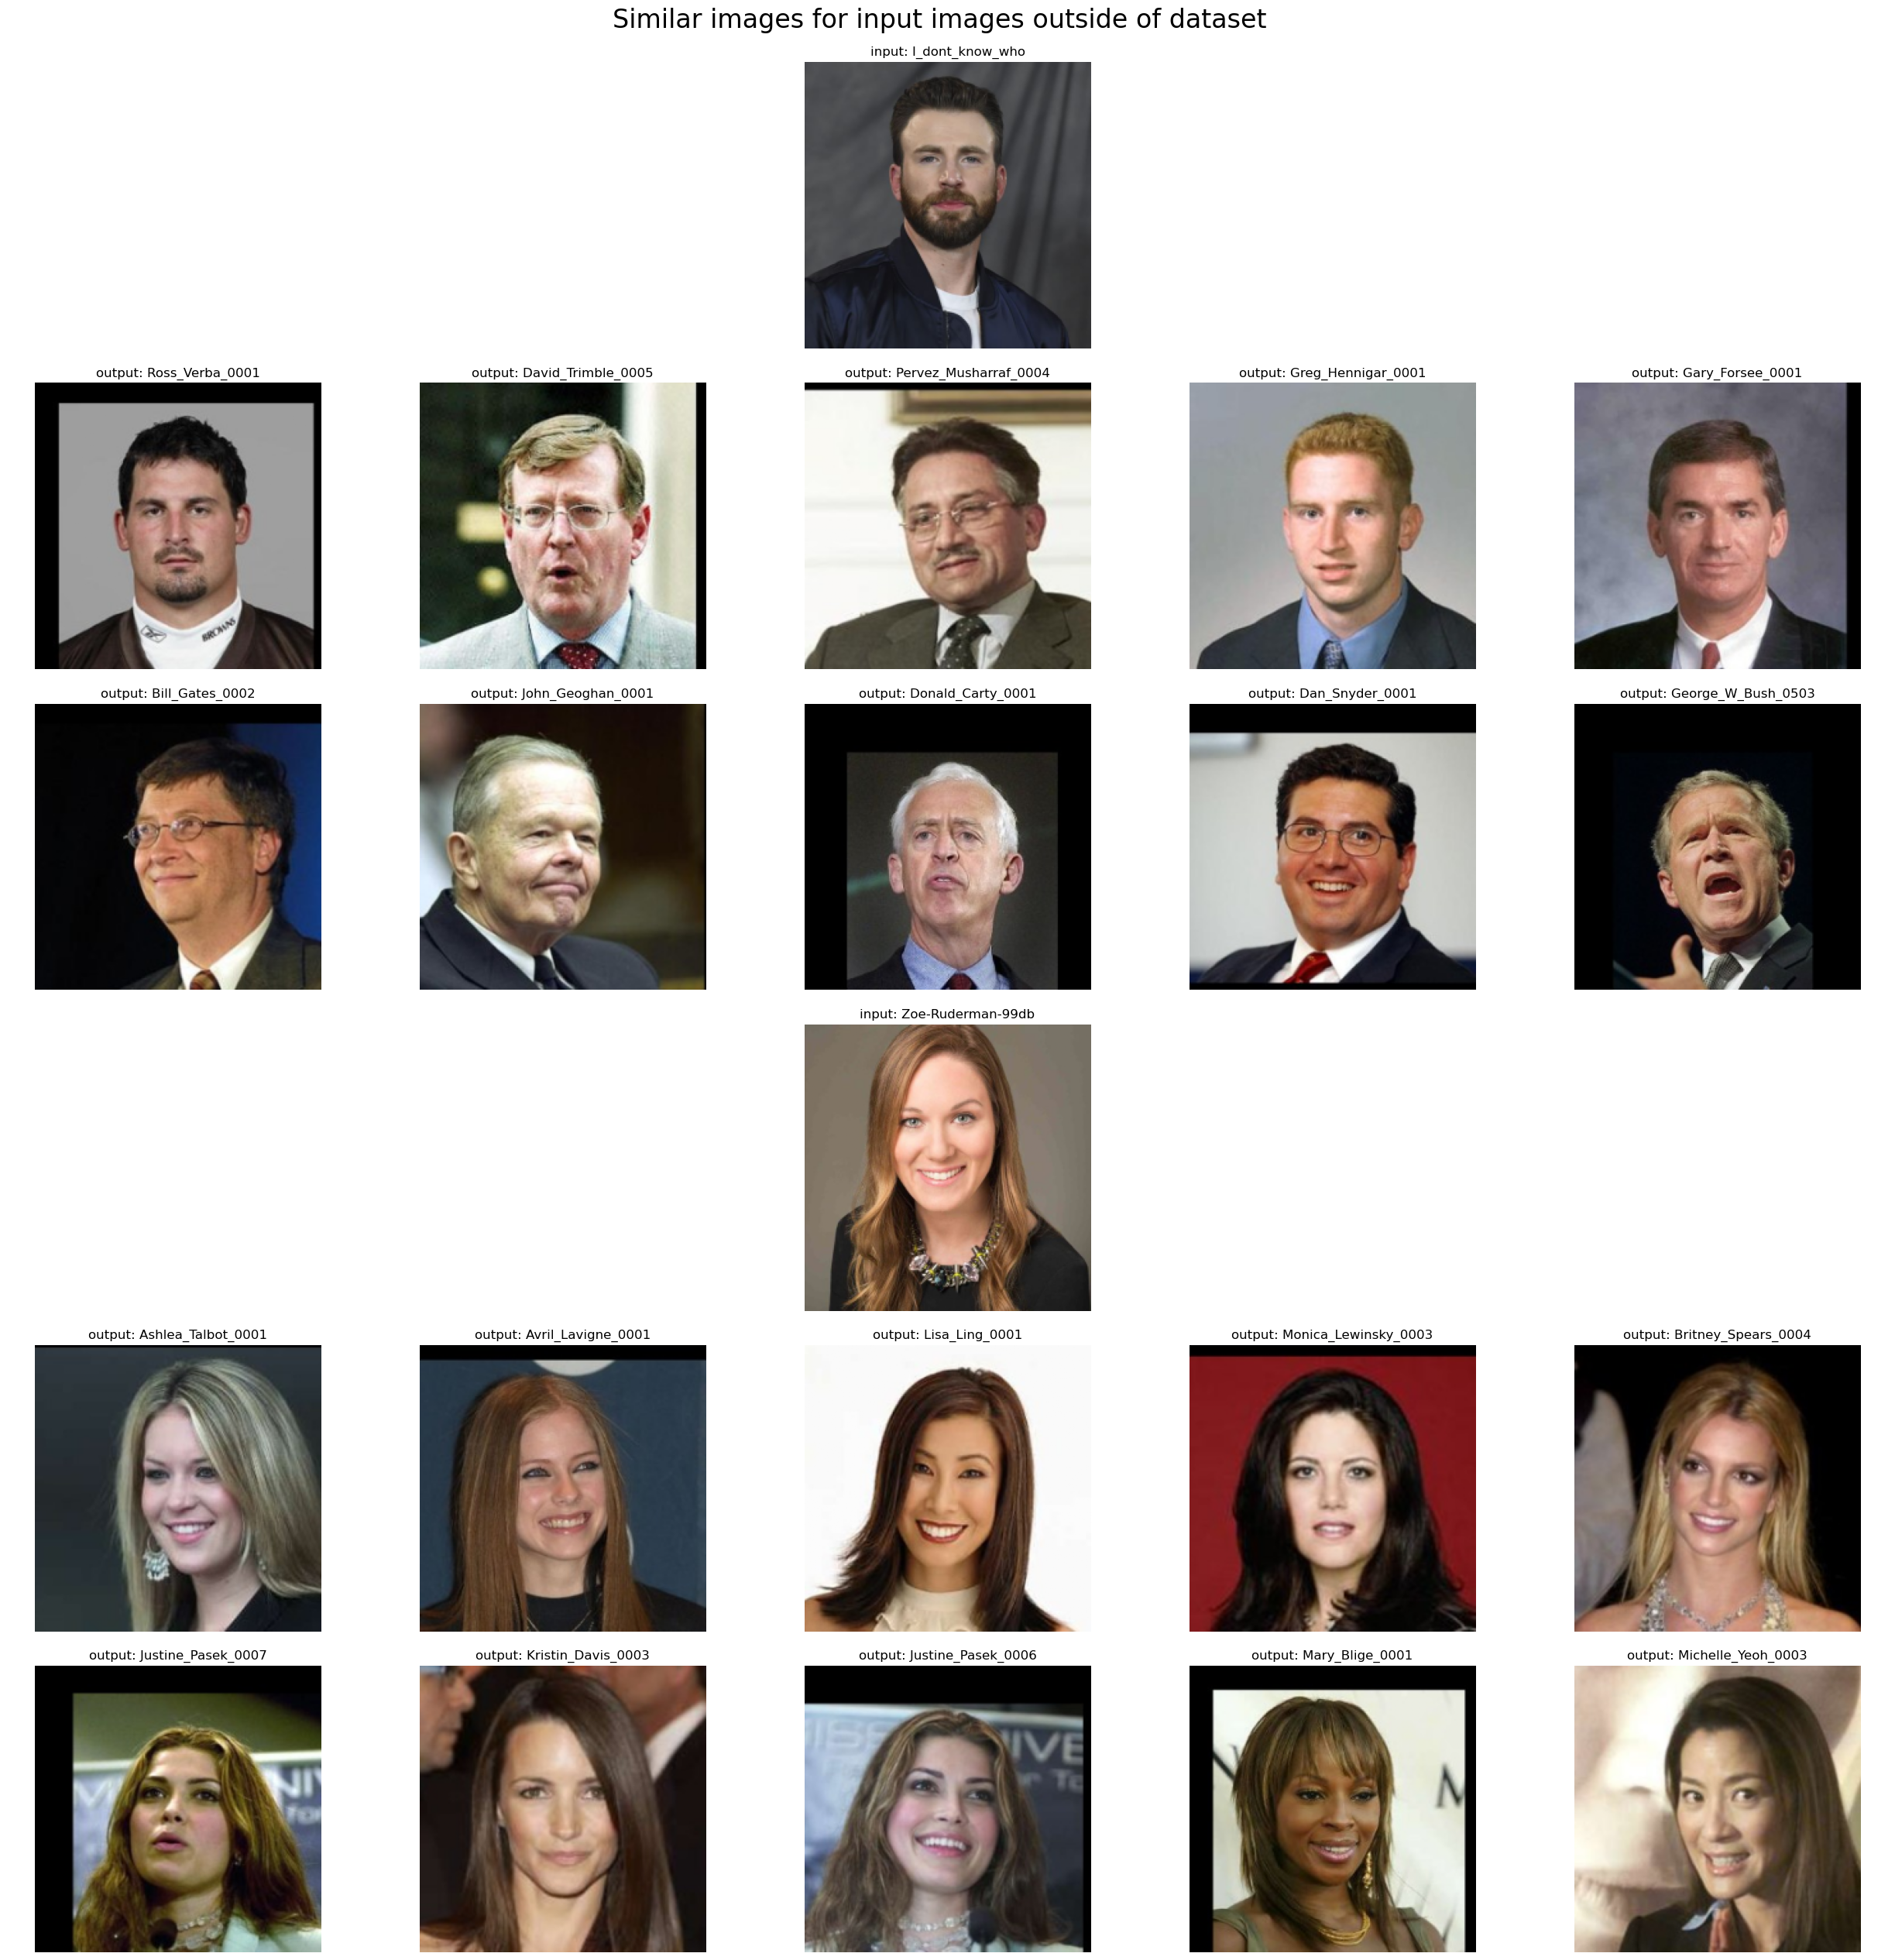

In [12]:
# print similar images indata
fig, axes = plt.subplots(int(len(testimgslist)*3), int(sim_img_size/2), figsize=(25, 25))
fig.tight_layout()

# hide all subplots axis
for axr in axes:
    for ax in axr:
        ax.set_axis_off()
        
for i, r in enumerate(range(0, len(axes), 3)):
    # plot original images
    testimg = test_imgs[i].to('cpu').numpy()
    testimg_name = re.split(r'\\|\.', testimgslist[i])[-2]
    axes[r, int(sim_img_size/4)].set_title('input: ' + testimg_name)
    axes[r, int(sim_img_size/4)].imshow(testimg[:,:,::-1])
    # plot similar images
    for k in range(0, sim_img_size):
        pr = r + 1 if  k < int(sim_img_size/2) else r + 2
        pl = k % int(sim_img_size/2)
        testimg = data[outdata_similar_indices[i][k]].to('cpu').numpy()
        testimg_name = re.split(r'\\|\.', filelist[outdata_similar_indices[i][k]])[-2]
        axes[pr, pl].set_title('output: ' + testimg_name)
        axes[pr, pl].imshow(testimg[:,:,::-1])
fig.suptitle('Similar images for input images outside of dataset', y=1.02, fontsize=24)
plt.show()

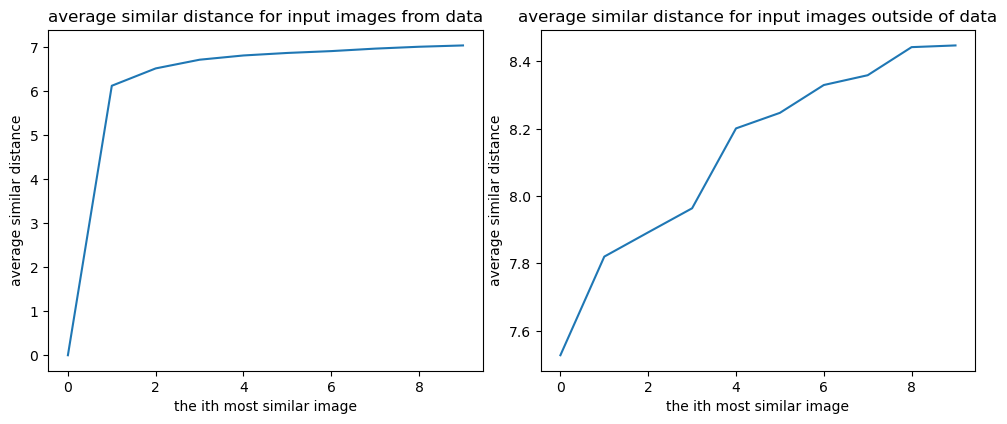

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout()
ax1.plot(range(sim_img_size), indata_similar_dists.mean(axis=0))
ax1.set_title('average similar distance for input images from data')
ax1.set_xlabel('the ith most similar image')
ax1.set_ylabel('average similar distance')
ax2.plot(range(sim_img_size), outdata_similar_dists.mean(axis=0))
ax2.set_title('average similar distance for input images outside of data')
ax2.set_xlabel('the ith most similar image')
ax2.set_ylabel('average similar distance')
plt.show()